Note: 
    
Only run for winter, since we do clustering here.

In [9]:
import numpy as np
import scipy.io as sio

import pandas as pd
import datetime as dt
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
from sklearn.cluster import HDBSCAN

In [3]:
rootdir = '/global/cfs/projectdirs/m1657/liuy351/TallTower/'


In [4]:
opt_model = 'R18'

In [5]:
ts_full = pd.date_range('2001-01-01 00:00', end='2020-12-31 23:00', freq='h')

## 1. Run a classifier to cluster weather systems

### 1.1 20 years

In [6]:
distance_matrix = xr.open_dataarray('ResNet_output/R18_distance_matrix.2015-2020.ERA5.nc')
distance_matrix

<xarray.DataArray (x: 52608, y: 52608)> Size: 22GB
[2767601664 values with dtype=float64]
Dimensions without coordinates: x, y
Attributes:
    description:  Calculate the distance matrix for reducing the computation ...
    script:       /global/cfs/projectdirs/m1657/liuy351/TallTower/03.clusteri...

In [11]:
# kmean_results = {}

# #for nclass in np.arange(2, 3, 1):

# for nclass in np.arange(2, 42, 1):

#     print(nclass)
#     print(' start ', dt.datetime.now())
#     kmean_model = KMeans(n_clusters=nclass, n_init=10, random_state=42)
#     kmean_results['C%d'%nclass] = kmean_model.fit(full_NCLtag).labels_
#     print(' end ', dt.datetime.now())

# results = {}

# PARAM = ({"min_cluster_size": 5}, {"min_cluster_size": 3}, {"min_cluster_size": 25})
# for i, param in enumerate(PARAM):
#     hdb = HDBSCAN(**param).fit(full_NCLtag)
#     labels = hdb.labels_
  
# results = {}
# for min_cluster_size in [120, 240, 360, 480]:
for min_cluster_size in [4,]:
    t1 = dt.datetime.now()
    hdbscan_model = HDBSCAN(metric='precomputed', min_cluster_size=min_cluster_size)
    results[f'mcs{min_cluster_size}'] = hdbscan_model.fit_predict(distance_matrix.data)
    t2 = dt.datetime.now()
    print(t2 - t1)

0:01:06.960087


array([  -1,    0,    1, ..., 6438, 6439, 6440])

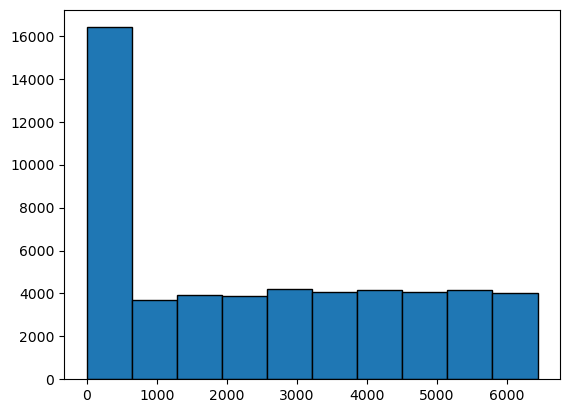

In [10]:
min_cluster_size = 3
freq, edges = np.histogram(results[f'mcs{min_cluster_size}'])
fig, ax = plt.subplots()
ax.bar(edges[:-1], freq, width=np.diff(edges), edgecolor="black", align="edge")
np.unique(results[f'mcs{min_cluster_size}'])

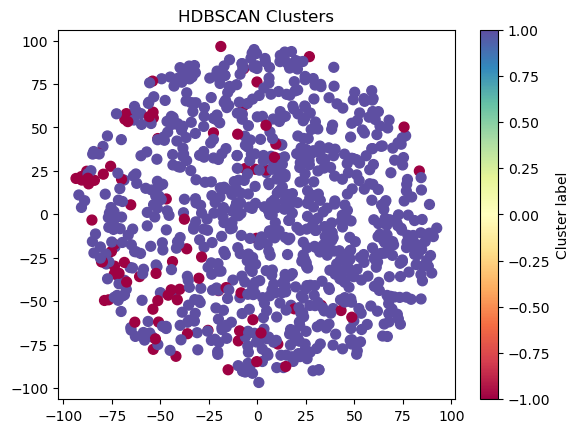

In [30]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Reduce dimensions (this can be slow for large datasets)
# data_embedded = TSNE(init='random', n_components=2, metric='precomputed').fit_transform(distance_matrix)

# Plot
# plt.scatter(data_embedded[:, 0], data_embedded[:, 1], c=cluster_labels, cmap='Spectral', s=50)
plt.scatter(data_embedded[::100, 0], data_embedded[::100, 1], c=results[f'mcs{min_cluster_size}'][::100], cmap='Spectral', s=30)
plt.title('HDBSCAN Clusters')
plt.colorbar(label='Cluster label')
plt.show()

In [17]:
tag_20year = (ts_full.year>=2015)&(ts_full.year<=2020)
print(tag_20year.shape, tag_20year.sum())

(175320,) 52608


In [18]:
infile = rootdir + 'ResNet_output/%s_output.anomaly.2001-2020.ERA5.mat' % opt_model
print(infile)
inds = sio.loadmat(infile)
full_NCLtag = inds['ResNetoutput'][tag_20year==1]

print(full_NCLtag.shape)

/global/cfs/projectdirs/m1657/liuy351/TallTower/ResNet_output/R18_output.anomaly.2001-2020.ERA5.mat
(52608, 512)


In [ ]:
results1 = {}
for min_cluster_size in [120, 240, 360, 480]:
    t1 = dt.datetime.now()
    results1[f'mcs{min_cluster_size}'] = HDBSCAN(min_cluster_size=min_cluster_size).fit(full_NCLtag).labels_
    t2 = dt.datetime.now()
    print(t2 - t1)

In [12]:
kmean_results['year'] = np.array(ts_full.year[tag_winter_40year])
kmean_results['month'] = np.array(ts_full.month[tag_winter_40year])
kmean_results['day'] = np.array(ts_full.day[tag_winter_40year])

In [13]:
tmpfile = rootdir + 'intermediate_data/weather_clustering/RH_input/%s.weather_clustering.40year_training.mat' % opt_model

kmean_results['script'] = '/global/cfs/projectdirs/m1657/liuy351/TallTower/From_XD/step03.clustering_production_run.ipynb'
kmean_results['note'] = 'Only for Oct-Mar. Use pandas to create a time series and filter out data. K-means trained using 40-year data. Not training-testing split'

sio.savemat(tmpfile, kmean_results)

### 1.2 30 year as training, then applied to 40 years

In [14]:
tag_winter_30year = (ts_full.year<=2010)&((ts_full.month>=10)|(ts_full.month<=3))
print(tag_winter_30year.shape, tag_winter_30year.sum())

(14610,) 5467


In [15]:
infile = rootdir + 'ResNet_output/RH_input/%s_output.anomaly.daymean.1981-2020.ERA5.mat' % opt_model

inds = sio.loadmat(infile)
full_NCLtag_training = inds['ResNetoutput'][tag_winter_30year==1]
full_NCLtag_prediction = inds['ResNetoutput'][tag_winter_40year==1]

print(full_NCLtag_training.shape, full_NCLtag_prediction.shape)

(5467, 512) (7290, 512)


In [16]:
kmean_results = {}

#for nclass in np.arange(2, 3, 1):

for nclass in np.arange(2, 42, 1):

    print(nclass)
    print(' start ', dt.datetime.now())
    kmean_model = KMeans(n_clusters=nclass, n_init=10, random_state=42)
    whatever_output = kmean_model.fit(full_NCLtag_training).labels_
    kmean_results['C%d'%nclass] = kmean_model.predict(full_NCLtag_prediction)
    print(' end ', dt.datetime.now())

2
 start  2024-06-19 11:10:55.501459
 end  2024-06-19 11:10:55.880185
3
 start  2024-06-19 11:10:55.880309
 end  2024-06-19 11:10:56.385458
4
 start  2024-06-19 11:10:56.385590
 end  2024-06-19 11:10:57.085500
5
 start  2024-06-19 11:10:57.085629
 end  2024-06-19 11:10:58.291042
6
 start  2024-06-19 11:10:58.291165
 end  2024-06-19 11:10:59.071790
7
 start  2024-06-19 11:10:59.071907
 end  2024-06-19 11:10:59.763407
8
 start  2024-06-19 11:10:59.763523
 end  2024-06-19 11:11:00.893178
9
 start  2024-06-19 11:11:00.893292
 end  2024-06-19 11:11:02.164450
10
 start  2024-06-19 11:11:02.164573
 end  2024-06-19 11:11:03.555322
11
 start  2024-06-19 11:11:03.555461
 end  2024-06-19 11:11:04.955148
12
 start  2024-06-19 11:11:04.955287
 end  2024-06-19 11:11:06.196121
13
 start  2024-06-19 11:11:06.196235
 end  2024-06-19 11:11:07.567761
14
 start  2024-06-19 11:11:07.567889
 end  2024-06-19 11:11:09.001734
15
 start  2024-06-19 11:11:09.001845
 end  2024-06-19 11:11:10.702496
16
 start  202

In [17]:
kmean_results['year'] = np.array(ts_full.year[tag_winter_40year])
kmean_results['month'] = np.array(ts_full.month[tag_winter_40year])
kmean_results['day'] = np.array(ts_full.day[tag_winter_40year])

In [19]:
tmpfile = rootdir + 'intermediate_data/weather_clustering/RH_input/%s.weather_clustering.30year_training.mat' % opt_model

kmean_results['script'] = '/global/cfs/projectdirs/m1657/liuy351/TallTower/From_XD/step03.clustering_production_run.ipynb'
kmean_results['note'] = 'Only for Oct-Mar. Use pandas to create a time series and filter out data. K-means trained using 30-year data (1981-2010). 2011-2020 are prediction'

sio.savemat(tmpfile, kmean_results)

### 1.3 20-year as training

In [20]:
tag_winter_20year = (ts_full.year<=2000)&((ts_full.month>=10)|(ts_full.month<=3))
print(tag_winter_20year.shape, tag_winter_20year.sum())

(14610,) 3645


In [21]:
infile = rootdir + 'ResNet_output/RH_input/%s_output.anomaly.daymean.1981-2020.ERA5.mat' % opt_model

inds = sio.loadmat(infile)
full_NCLtag_training = inds['ResNetoutput'][tag_winter_20year==1]
full_NCLtag_prediction = inds['ResNetoutput'][tag_winter_40year==1]

print(full_NCLtag_training.shape, full_NCLtag_prediction.shape)

(3645, 512) (7290, 512)


In [22]:
kmean_results = {}

#for nclass in np.arange(2, 3, 1):

for nclass in np.arange(2, 42, 1):

    print(nclass)
    print(' start ', dt.datetime.now())
    kmean_model = KMeans(n_clusters=nclass, n_init=10, random_state=42)
    whatever_output = kmean_model.fit(full_NCLtag_training).labels_
    kmean_results['C%d'%nclass] = kmean_model.predict(full_NCLtag_prediction)
    print(' end ', dt.datetime.now())

2
 start  2024-06-19 11:12:34.943046
 end  2024-06-19 11:12:35.254898
3
 start  2024-06-19 11:12:35.255035
 end  2024-06-19 11:12:35.676436
4
 start  2024-06-19 11:12:35.676569
 end  2024-06-19 11:12:36.185417
5
 start  2024-06-19 11:12:36.185535
 end  2024-06-19 11:12:36.778853
6
 start  2024-06-19 11:12:36.778966
 end  2024-06-19 11:12:37.376690
7
 start  2024-06-19 11:12:37.376788
 end  2024-06-19 11:12:38.196203
8
 start  2024-06-19 11:12:38.196315
 end  2024-06-19 11:12:39.093319
9
 start  2024-06-19 11:12:39.093435
 end  2024-06-19 11:12:39.896669
10
 start  2024-06-19 11:12:39.896775
 end  2024-06-19 11:12:40.996252
11
 start  2024-06-19 11:12:40.996359
 end  2024-06-19 11:12:41.957062
12
 start  2024-06-19 11:12:41.957160
 end  2024-06-19 11:12:42.777701
13
 start  2024-06-19 11:12:42.777815
 end  2024-06-19 11:12:43.765905
14
 start  2024-06-19 11:12:43.766009
 end  2024-06-19 11:12:44.868077
15
 start  2024-06-19 11:12:44.868187
 end  2024-06-19 11:12:45.955201
16
 start  202

In [23]:
kmean_results['year'] = np.array(ts_full.year[tag_winter_40year])
kmean_results['month'] = np.array(ts_full.month[tag_winter_40year])
kmean_results['day'] = np.array(ts_full.day[tag_winter_40year])

In [24]:
tmpfile = rootdir + 'intermediate_data/weather_clustering/RH_input/%s.weather_clustering.20year_training.mat' % opt_model

kmean_results['script'] = '/global/cfs/projectdirs/m1657/liuy351/TallTower/From_XD/step03.clustering_production_run.ipynb'
kmean_results['note'] = 'Only for Oct-Mar. Use pandas to create a time series and filter out data. K-means trained using 20-year data (1981-2010). 2001-2020 are prediction'

sio.savemat(tmpfile, kmean_results)

In [26]:
kmean_results['C17']

array([ 4,  2,  2, ...,  7,  6, 13], dtype=int32)